In [109]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import plot_digi

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

C:\Users\VGeorgiev\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [10]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [22]:
x, y = mnist['data'], mnist['target']

In [24]:
x.shape, y.shape

((70000, 784), (70000,))

In [47]:
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

## Visualize image

In [34]:
random_image = x[0]
random_image_2d = random_image.reshape(28, 28)

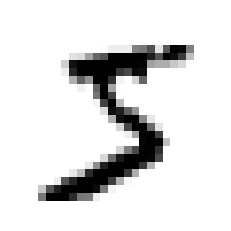

In [50]:
plt.imshow(random_image_2d, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

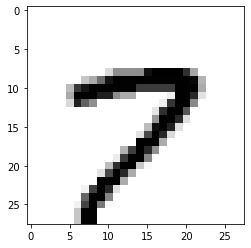

In [49]:

plt.imshow(x[123].reshape(28,28), cmap=mpl.cm.binary)

In [51]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

## One-digit detector (binary detector)

In [52]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [58]:
model = SGDClassifier(random_state=42)
model.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
model.predict([x_train[0]])

array([ True])

## Validation

In [64]:
cross_val_score(model, x_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This is pretty high accuracy, but we cannot be below 0.9 because we have only 10% images with five digit.

### Confusion Matrix

In [66]:
predicts = cross_val_predict(model, x_train, y_train_5, cv=3)

In [68]:
confusion_matrix(y_train_5, predicts) ## [TRUE Negative, False Positive],[False Negative, True Positive]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [70]:
confusion_matrix(y_train_5, y_train_5) # Perfect predictions

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision/Recall Tradeoff

In [75]:
precision_score(y_train_5, predicts), recall_score(y_train_5, predicts), f1_score(y_train_5, predicts)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

In [78]:
predict_scores = cross_val_predict(model, x_train, y_train_5, cv=3, method='decision_function')

In [79]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, predict_scores)

In [81]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.show()
    # highlight the threshold, add the legend, axis label and grid

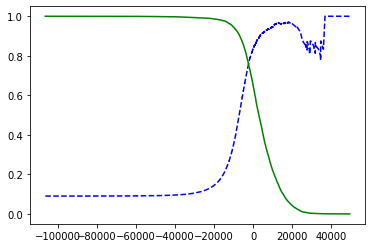

In [82]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [94]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (predict_scores >= threshold_90_precision)

In [97]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)
#If someone says “let’s reach 99% precision,” you should ask, “atwhat recall?”

(0.9000345901072293, 0.4799852425751706)

### ROC Curve

In [100]:
fpr, tpr, thresholds = roc_curve(y_train_5, predict_scores)

In [101]:
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  49442.43765905,   49441.43765905,   36801.60697028, ...,
        -105763.22240074, -106527.45300471, -146348.56726174]))

In [118]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal

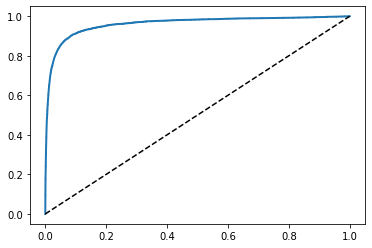

In [104]:
plot_roc_curve(fpr, tpr)

In [107]:
roc_auc_score(y_train_5, predict_scores)

0.9604938554008616

In [110]:
forest_clf = RandomForestClassifier(random_state=42)

In [114]:
forest_probas = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [115]:
forest_scores = forest_probas[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, forest_scores)

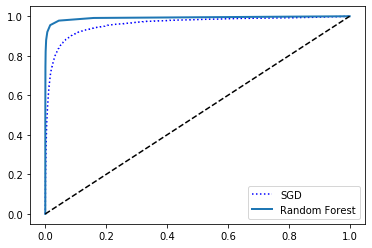

In [119]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [121]:
roc_auc_score(y_train_5, forest_scores)

0.9920527492698306

In [135]:
forest_predicts = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [136]:
precision_score(y_train_5, forest_predicts), recall_score(y_train_5, forest_predicts)

(0.986046511627907, 0.8212506917542889)

## Multiclass Classification

Strategies: **OneVsOneClassifier OneVsRestClassifier**. Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. Random Forest classifiers or naive Bayes classifiers are capable of handling multiple classes directly.

### TODO: Compare SGD Classifier with Random Forest Clasifier

In [144]:
m_sgd_classifier = SGDClassifier(random_state=42)
cross_val_score(m_sgd_classifier, x_train, y_train, cv = 3)

array([0.87082583, 0.87089354, 0.88628294])

In [143]:
m_forest_classifier = RandomForestClassifier()
cross_val_score(m_forest_classifier, x_train, y_train, cv=3, scoring='accuracy')

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.93896221, 0.9380969 , 0.94244137])

In [192]:
m_forest_predicts = cross_val_predict(m_forest_classifier, x_train, y_train, cv=3)

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\VGeorgiev\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [198]:
conf_mx = confusion_matrix(y_train, m_forest_predicts)
conf_mx

array([[5806,    4,   13,    8,   11,   13,   28,    3,   33,    4],
       [   1, 6628,   39,   17,   10,    5,    8,   12,   16,    6],
       [  53,   20, 5596,   54,   45,   19,   27,   59,   74,   11],
       [  25,   20,  147, 5631,    9,  126,   11,   55,   76,   31],
       [  17,   20,   25,    7, 5549,    6,   39,   27,   25,  127],
       [  51,   16,   28,  216,   34, 4927,   53,   12,   50,   34],
       [  52,   21,   24,    7,   27,   64, 5696,    0,   25,    2],
       [  10,   44,   92,   29,   71,   11,    1, 5896,   15,   96],
       [  40,   60,   95,  120,   57,  119,   40,   20, 5232,   68],
       [  33,   17,   41,   80,  162,   46,    4,   96,   58, 5412]],
      dtype=int64)

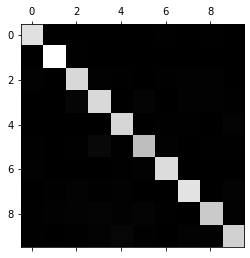

In [209]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [203]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

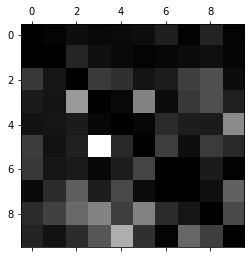

In [210]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [219]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [228]:
index = 7
y_train[index], knn_clf.predict([x_train[index]])

(3, array([[False,  True]]))

In [ ]:
knn_predicts = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)

In [ ]:
f1_score()